In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy import stats
np.random.seed(123)  # for reproducibility
from tqdm import tqdm
import os
from natsort import natsorted
from keras.optimizers import SGD
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import MaxPooling2D, Conv2D
# from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import keras.callbacks

import tensorflow as tf
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [7]:
df = pd.read_csv("meta-data/sample_submission.csv")
df.head()

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,0.461052,0.160543,0.596985,0.112976,0.514793,0.795334,0.329462,0.956140,0.150305,...,0.097436,0.960740,0.586314,0.358086,0.632356,0.129911,0.970917,0.075613,0.891457,0.353058
1,Img-2.jpg,0.391038,0.015032,0.808050,0.229542,0.632174,0.557231,0.993525,0.392024,0.344499,...,0.980599,0.252298,0.882384,0.666060,0.404774,0.244035,0.319077,0.399242,0.282049,0.510206
2,Img-3.jpg,0.686004,0.862929,0.661918,0.725864,0.610226,0.463240,0.482999,0.377200,0.708358,...,0.763146,0.101021,0.725597,0.252975,0.804369,0.599251,0.300347,0.513784,0.337301,0.045477
3,Img-4.jpg,0.702411,0.557327,0.143711,0.693352,0.008305,0.807822,0.920738,0.446771,0.891311,...,0.406623,0.605928,0.085137,0.706568,0.325001,0.591561,0.246156,0.879007,0.130129,0.113896
4,Img-5.jpg,0.097772,0.376566,0.127358,0.713473,0.516010,0.548523,0.755888,0.428397,0.378050,...,0.152309,0.445195,0.466826,0.081746,0.180878,0.526940,0.838946,0.045366,0.001368,0.653959


In [8]:
cols = list(df.columns)
cols.remove("image_id")

In [9]:
def load_top_model_densenet():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(1920,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(30, activation='softmax'))
    return model

In [11]:
base_model = DenseNet201(include_top=False, pooling='avg')
top = load_top_model_densenet()

x = top(base_model.outputs)
model = Model(inputs=base_model.inputs, outputs=x)
model.load_weights('checkpoints/DenseNet/weights_unfreezed_20.05-0.20.hdf5')
# model = load_model('checkpoints/DenseNet/weights_unfreezed_0.12-0.27.hdf5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [12]:
model.input_shape

(None, None, None, 3)

In [13]:
resol = 224

In [14]:
pred_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
gen = pred_datagen.flow_from_directory(
        'predict_data/',  # this is the target directory
        target_size=(resol, resol),
        batch_size=30,
        class_mode=None,
        shuffle=False) 

Found 6000 images belonging to 1 classes.


In [16]:
preds = model.predict_generator(gen, steps=200, verbose=1)

200/200 [==============================] - 567s 3s/step


In [17]:
preds.shape

(6000, 30)

In [18]:
df = pd.DataFrame(preds, columns=cols)
df["image_id"] = gen.filenames
df = df[["image_id"] + cols]

In [19]:
def f(x):
    if x.startswith("predict/"):
        return x[8:]
df["image_id"] = df["image_id"].apply(f)
df.head()

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,5.759651e-08,6.744008e-08,2.206380e-07,3.158719e-07,9.998795e-01,3.317318e-09,1.316571e-07,9.266975e-08,2.062421e-07,...,2.011017e-07,7.086748e-08,9.588374e-05,2.162491e-07,5.097954e-07,1.046315e-07,1.049339e-07,1.509978e-08,1.922397e-09,1.175782e-07
1,Img-10.jpg,1.582305e-05,2.094319e-05,4.275419e-05,3.346725e-05,6.865512e-06,4.653495e-06,3.343692e-05,7.549534e-05,9.985934e-01,...,7.549982e-06,1.467741e-05,1.656008e-04,1.661974e-04,1.972794e-06,1.977740e-05,3.049177e-04,6.131602e-05,5.340257e-06,5.128373e-06
2,Img-100.jpg,4.660627e-07,1.635300e-06,7.843225e-07,1.896670e-06,3.769126e-05,1.965696e-06,4.268330e-06,2.725233e-05,2.325107e-05,...,2.525329e-05,9.984346e-07,2.231857e-06,4.203340e-05,1.373132e-07,3.196795e-06,5.872286e-06,4.617974e-06,5.540430e-07,9.997631e-01
3,Img-1000.jpg,1.900522e-07,5.249043e-08,2.724360e-06,1.409736e-07,7.934689e-08,1.463806e-08,4.015914e-07,1.376867e-06,9.999630e-01,...,8.387786e-08,1.126800e-07,4.433898e-07,1.165594e-06,7.069693e-08,4.397867e-07,1.121745e-06,1.002418e-06,4.572650e-08,1.105518e-08
4,Img-1001.jpg,1.316085e-07,6.635531e-08,4.927242e-07,1.961898e-07,7.282544e-06,6.330533e-08,9.999582e-01,1.689645e-07,5.056796e-08,...,3.308082e-07,9.040232e-08,1.243403e-07,1.050100e-08,1.161355e-08,1.140742e-05,4.067522e-08,1.867402e-07,1.764099e-08,7.832459e-07


In [20]:
fnames = os.listdir("predict_data/predict/")
fnames = natsorted(fnames)
df = df.set_index("image_id")
df = df.reindex(fnames)

In [21]:
df.head()

,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,german+shepherd,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
image_id,,,,,,,,,,,,,,,,,,,,,
Img-1.jpg,5.759651e-08,6.744008e-08,2.206380e-07,3.158719e-07,0.999879,3.317318e-09,1.316571e-07,9.266975e-08,2.062421e-07,4.096960e-08,...,2.011017e-07,7.086748e-08,9.588374e-05,2.162491e-07,5.097954e-07,1.046315e-07,1.049339e-07,1.509978e-08,1.922397e-09,1.175782e-07
Img-2.jpg,1.020952e-03,2.542272e-04,1.190611e-03,7.419388e-02,0.001038,6.304860e-04,3.238012e-04,1.266594e-03,2.807317e-03,7.461094e-04,...,1.225591e-03,2.991070e-03,3.100477e-02,2.402859e-01,1.139419e-01,2.534811e-04,1.571868e-02,2.997708e-02,9.263052e-04,1.465941e-04
Img-3.jpg,5.409082e-05,1.891454e-05,8.831739e-05,3.264090e-04,0.008324,5.983909e-06,1.037469e-04,1.266537e-05,2.987621e-05,1.841805e-05,...,5.008309e-06,2.715612e-05,9.709949e-01,1.471002e-05,8.341830e-06,1.159057e-05,8.406245e-06,7.529850e-06,3.866265e-05,8.900760e-05
Img-4.jpg,1.166556e-06,2.236060e-05,1.197839e-05,6.663166e-06,0.000005,1.276568e-04,1.361898e-05,6.784976e-06,4.141608e-06,6.391039e-05,...,9.981012e-01,7.996139e-05,7.069166e-08,3.109074e-06,1.670814e-04,2.558160e-05,1.278032e-05,7.547142e-07,2.047216e-04,1.253476e-04
Img-5.jpg,8.655653e-05,1.236510e-01,9.638336e-04,2.099580e-05,0.000214,9.396331e-04,3.951996e-04,6.322648e-04,5.350556e-05,1.558411e-03,...,2.429023e-02,9.288353e-03,1.820542e-04,4.636423e-04,8.700871e-04,7.281246e-05,2.485063e-04,3.127716e-04,1.109045e-03,4.626062e-04


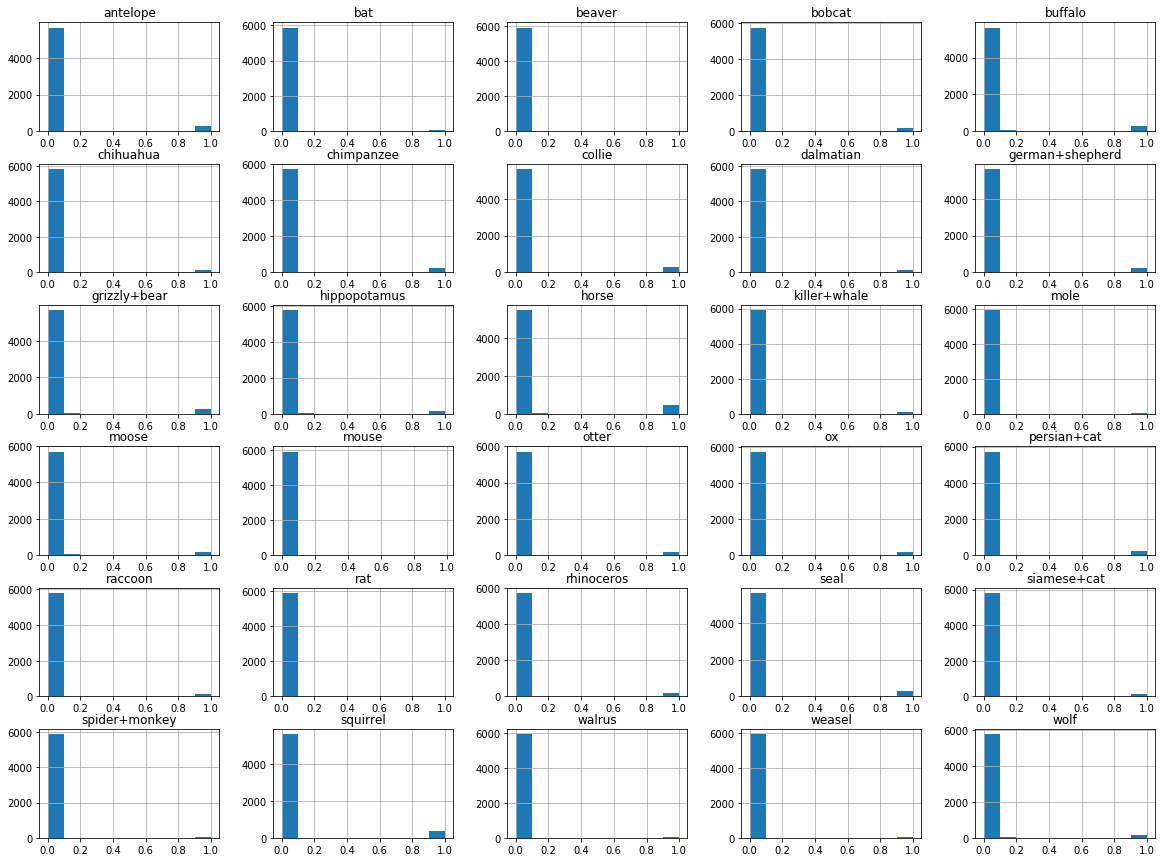

In [22]:
_ = df.hist(figsize=(20, 15), bins=10)

In [23]:
df.to_csv("SUB/Sub7.csv", index=True)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
model.targets

[<tf.Tensor 'dense_2_target:0' shape=(?, ?) dtype=float32>]

In [18]:
impath = "predict_data/predict/Img-3.jpg"
X = img_to_array(load_img(impath, target_size=(resol, resol)))
X = X.reshape((1,) + X.shape) / 255
prob = model.predict(X)
prob

array([[4.00752366e-01, 5.59667184e-04, 2.90706265e-03, 1.27661566e-03,
        2.02479735e-02, 2.51301681e-03, 6.22969447e-03, 6.20153919e-03,
        2.39330620e-04, 7.76460022e-02, 3.50667983e-02, 1.31926369e-02,
        2.33098608e-03, 9.31539282e-04, 2.63903625e-02, 3.65438849e-01,
        4.50420892e-03, 5.67967165e-03, 7.51861779e-04, 3.06578761e-04,
        1.12881549e-02, 1.36711274e-03, 5.30757103e-03, 8.61400459e-03,
        5.34462561e-05, 1.12791695e-02, 8.24549049e-03, 5.09580655e-04,
        2.20169546e-03, 1.96612980e-02]], dtype=float32)

In [19]:
prob[prob >= 0.5] = 1
prob[prob < 0.5] = 0
prob

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)